In [ ]:
# Add your libraries here
import numpy as np
import os
import copy
import time
import cv2
import glob
import re
import tifffile
import shutil
import zipfile

from google.colab import drive
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from PIL import Image
from collections import defaultdict

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/EGY_BCD.zip'

# Path to extract the dataset
extracted_path = '/content/dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Check the extracted files
extracted_files = os.listdir(extracted_path)
print("Extracted files:", extracted_files)

Mounted at /content/drive
Extracted files: ['256']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def natural_sort_key(s):
    """Key function for natural sorting."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_images(class_name):
    images = []
    dataset_path = '/content/dataset/256/'
    class_path = os.path.join(dataset_path, class_name)

    # Use glob to find files matching the pattern '*.png' and sort them numerically
    filenames = sorted(glob.glob(os.path.join(class_path, '*.png')), key=natural_sort_key)

    for filename in filenames:
        image = Image.open(filename)
        images.append(image)

    return images


# Load images for each class
a_images = np.asarray(load_images('A'))
b_images = np.asarray(load_images('B'))
label_images = np.asarray(load_images('label'))

print("Number of A images:", len(a_images))
print("Number of B images:", len(b_images))
print("Number of label images:", len(label_images))

Number of A images: 6091
Number of B images: 6091
Number of label images: 6091


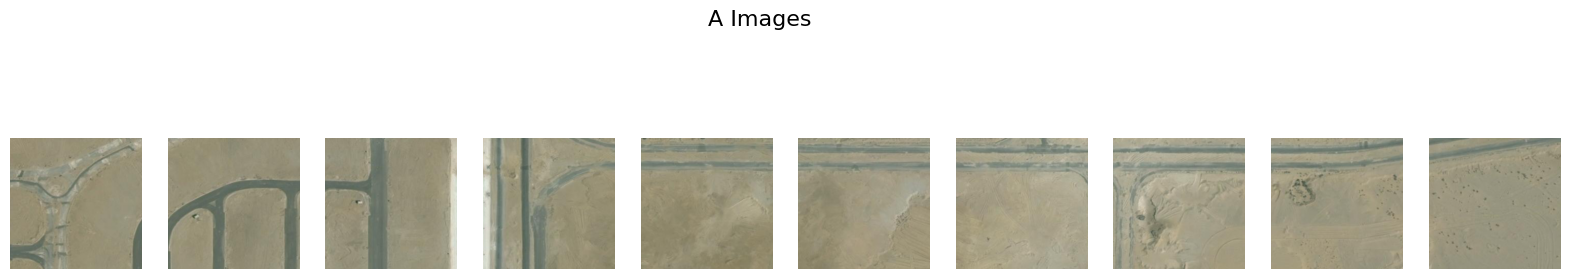

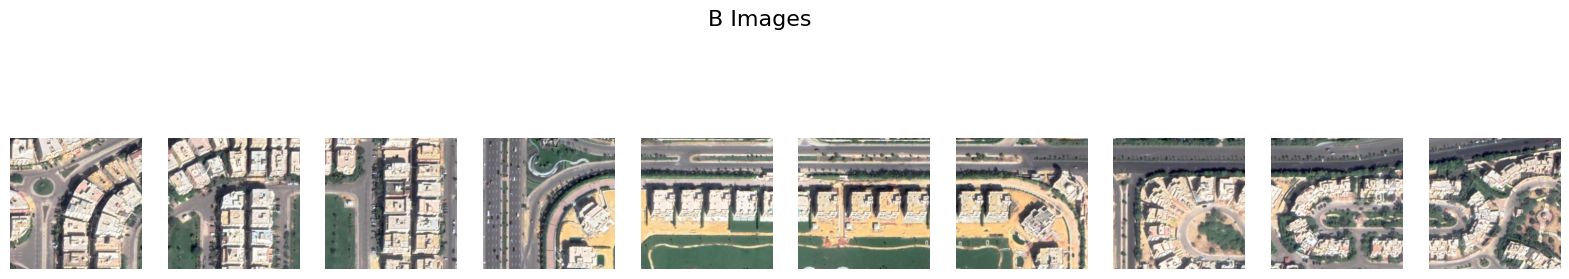

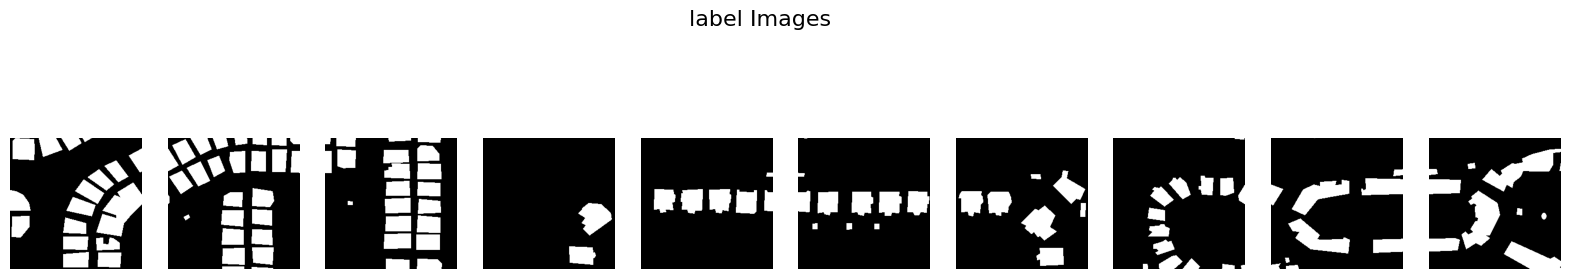

In [ ]:
def display_images(images, title):
    fig, axs = plt.subplots(1, 10, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        img_array = np.array(images[i])
        if len(img_array.shape) == 3 and img_array.shape[2] == 4:  # Check if the image has an alpha channel
            img_array = img_array[:, :, :3]  # Display only RGB channels
        if len(img_array.shape) == 2:  # Grayscale image, convert to RGB
            img_array = np.stack((img_array,) * 3, axis=-1)
        axs[i].imshow(img_array)
        axs[i].axis('off')

    plt.show()

display_images(a_images[70:80], 'A Images')
display_images(b_images[70:80], 'B Images')
display_images(label_images[70:80], 'label Images')


In [ ]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, A_folder, B_folder, labels_folder, transform=None):
        self.A_folder = A_folder
        self.B_folder = B_folder
        self.labels_folder = labels_folder
        self.transform = transform

        self.file_names = os.listdir(A_folder)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]

        img_A = Image.open(os.path.join(self.A_folder, file_name)).convert('RGB')  # Ensure RGB channels
        img_B = Image.open(os.path.join(self.B_folder, file_name)).convert('RGB')
        label = Image.open(os.path.join(self.labels_folder, file_name)).convert('L')

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
            label = self.transform(label)

        # Concatenate img_A and img_B along the channel dimension (dim=0 for batch)
        img_combined = torch.cat((img_A, img_B), dim=0)

        return img_combined, label

def get_data_loaders(A_folder, B_folder, labels_folder, batch_size=25, shuffle=True, num_workers=0):
    trans = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set = ChangeDetectionDataset(A_folder, B_folder, labels_folder, transform=trans)
    val_set = ChangeDetectionDataset(A_folder, B_folder, labels_folder, transform=trans)
    test_set = ChangeDetectionDataset(A_folder, B_folder, labels_folder, transform=trans)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    return dataloaders

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        # TODO: Define needed layers, use n_class variable in the last layer.

        # Define the encoder layers
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)  # Input channels are 6 (3 from img_A and 3 from img_B)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()

        # Define the decoder layers
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.relu9 = nn.ReLU()
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu10 = nn.ReLU()

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv11 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.relu11 = nn.ReLU()
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu12 = nn.ReLU()

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv13 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu13 = nn.ReLU()
        self.conv14 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu14 = nn.ReLU()

        # Define the output layer
        self.conv15 = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out1 = out
        out = self.maxpool1(out)

        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out2 = out
        out = self.maxpool2(out)

        out = self.conv5(out)
        out = self.relu5(out)
        out = self.conv6(out)
        out = self.relu6(out)
        out3 = out
        out = self.maxpool3(out)

        # Base convolutional layers
        out = self.conv7(out)
        out = self.relu7(out)
        out = self.conv8(out)
        out = self.relu8(out)

        # Decoder
        out = self.upconv1(out)
        out = torch.cat((out, out3), dim=1)
        out = self.conv9(out)
        out = self.relu9(out)
        out = self.conv10(out)
        out = self.relu10(out)

        out = self.upconv2(out)
        out = torch.cat((out, out2), dim=1)
        out = self.conv11(out)
        out = self.relu11(out)
        out = self.conv12(out)
        out = self.relu12(out)

        out = self.upconv3(out)
        out = torch.cat((out, out1), dim=1)
        out = self.conv13(out)
        out = self.relu13(out)
        out = self.conv14(out)
        out = self.relu14(out)

        out = self.conv15(out)

        return out

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def jaccard_index(pred, target):
    intersection = torch.sum(pred * target, dim=(2, 3))
    union = torch.sum(pred, dim=(2, 3)) + torch.sum(target, dim=(2, 3)) - intersection
    jaccard_per_image = torch.where(union == 0, torch.tensor(1.0), (intersection + 1e-10) / (union + 1e-10))
    return torch.mean(jaccard_per_image, dim=1)

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    jaccard_per_image = jaccard_index((pred > 0.5).float(), target)
    jaccard = torch.mean(jaccard_per_image)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['jaccard'] += jaccard.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    if phase != 'test':
        outputs.append("Jaccard Index: {:4f}".format(metrics['jaccard'] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, dataloaders, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs_combined, labels in dataloaders[phase]:
                inputs_combined = inputs_combined.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_combined)
                    loss = calc_loss(outputs, labels, metrics)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_samples += inputs_combined.size(0)

            if phase == 'train':
                scheduler.step()

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)
    return model


# Define paths to your folders
A_folder = '/content/dataset/256/A'
B_folder = '/content/dataset/256/B'
labels_folder = '/content/dataset/256/label'

# Define batch size and other parameters
batch_size = 25
shuffle = True
num_workers = 0
num_epochs = 5

# Get data loaders
dataloaders = get_data_loaders(A_folder, B_folder, labels_folder, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Define model
model = UNet(n_classes=1)  # Define number of classes appropriately

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Define scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
trained_model = train_model(model, optimizer, scheduler, dataloaders, num_epochs=num_epochs)


Epoch 0/4
----------


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train: bce: 0.459128, dice: 0.934830, jaccard: 0.640946, loss: 0.696979, Jaccard Index: 0.640946
val: bce: 0.266693, dice: 0.957346, jaccard: 0.640946, loss: 0.612019, Jaccard Index: 0.640946
saving best model
6m 11s
Epoch 1/4
----------
train: bce: 0.261477, dice: 0.957805, jaccard: 0.640946, loss: 0.609641, Jaccard Index: 0.640946
val: bce: 0.252054, dice: 0.960988, jaccard: 0.640946, loss: 0.606521, Jaccard Index: 0.640946
saving best model
6m 13s
Epoch 2/4
----------
train: bce: 0.246836, dice: 0.952885, jaccard: 0.640946, loss: 0.599860, Jaccard Index: 0.640946
val: bce: 0.231363, dice: 0.945125, jaccard: 0.640946, loss: 0.588244, Jaccard Index: 0.640946
saving best model
6m 17s
Epoch 3/4
----------
train: bce: 0.213685, dice: 0.927685, jaccard: 0.640946, loss: 0.570685, Jaccard Index: 0.640946
val: bce: 0.198936, dice: 0.923310, jaccard: 0.640946, loss: 0.561123, Jaccard Index: 0.640946
saving best model
6m 17s
Epoch 4/4
----------
train: bce: 0.192365, dice: 0.906153, jaccard: 0

In [ ]:
drive.flush_and_unmount()

In [ ]:
# Mount Google Drive again after we added the test set
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/test2.zip'

# Path to extract the dataset
extracted_path = '/content/test/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Check the extracted files
extracted_files = os.listdir(extracted_path)
print("Extracted files:", extracted_files)

Mounted at /content/drive
Extracted files: ['test0', 'A', 'label', 'test1', 'test2', 'B']


In [ ]:
def load_images(class_name):
    images = []
    dataset_path = '/content/test/test2/'
    class_path = os.path.join(dataset_path, class_name)

    # Use glob to find files matching the pattern '*.png' and sort them numerically
    filenames = sorted(glob.glob(os.path.join(class_path, '*.png')), key=natural_sort_key)

    for filename in filenames:
        image = Image.open(filename)
        images.append(image)

    return images
# Load images for each class
a_test_images = np.asarray(load_images('A'))
b_test_images = np.asarray(load_images('B'))

print("Number of A images:", len(a_test_images))
print("Number of B images:", len(b_test_images))

Number of A images: 10
Number of B images: 10


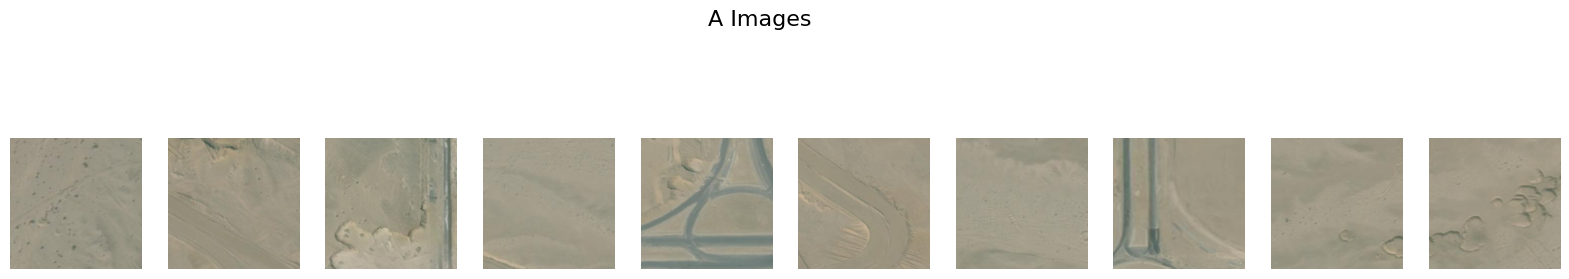

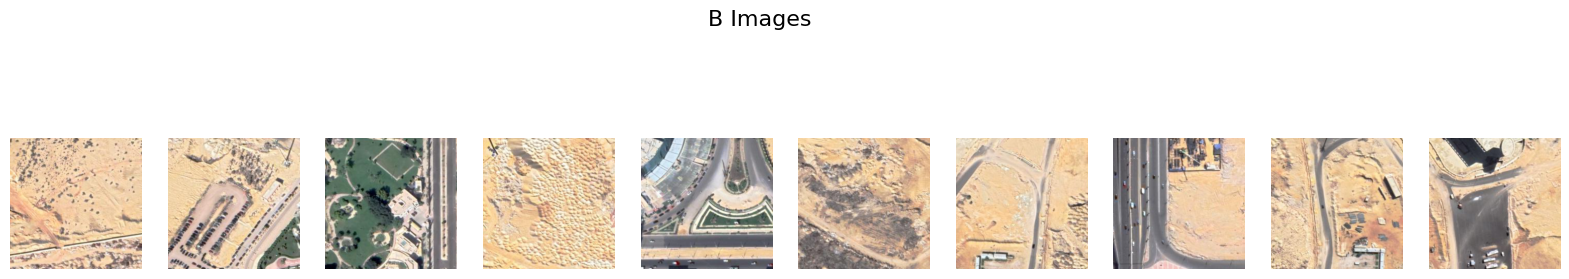

In [ ]:
display_images(a_test_images[:10], 'A Images')
display_images(b_test_images[:10], 'B Images')

In [51]:
class TestDataset(Dataset):
    def __init__(self, A_folder, B_folder, transform=None):
        self.A_folder = A_folder
        self.B_folder = B_folder
        self.transform = transform

        self.file_names_A = sorted(glob.glob(os.path.join(A_folder, '*.png')))
        self.file_names_B = sorted(glob.glob(os.path.join(B_folder, '*.png')))

    def __len__(self):
        return len(self.file_names_A)

    def __getitem__(self, idx):
        img_A = Image.open(self.file_names_A[idx]).convert('RGB')
        img_B = Image.open(self.file_names_B[idx]).convert('RGB')

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        img_combined = torch.cat((img_A, img_B), dim=0)

        return img_combined, os.path.basename(self.file_names_A[idx])

def get_test_loader(A_folder, B_folder, batch_size=25, num_workers=0):
    trans = transforms.Compose([
        transforms.ToTensor()
    ])

    test_set = TestDataset(A_folder, B_folder, transform=trans)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

# Define paths to your test folders
test_A_folder = '/content/test/test2/A'
test_B_folder = '/content/test/test2/B'

# Define batch size
test_batch_size = 25

# Get test data loader
test_loader = get_test_loader(test_A_folder, test_B_folder, batch_size=test_batch_size)

# Apply the trained model on the test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.eval()
trained_model.to(device)

# Create predictions folder if it doesn't exist
predictions_folder = '/content/predictions1'
os.makedirs(predictions_folder, exist_ok=True)

for inputs_combined, file_names in test_loader:
    inputs_combined = inputs_combined.to(device)
    outputs = trained_model(inputs_combined)
    predictions = torch.sigmoid(outputs)  # Applying sigmoid if necessary

    # Threshold the predictions
    binary_predictions = (predictions > 0.5).type(torch.uint8).cpu().numpy()

    # Save the predictions as images
    for i in range(len(file_names)):
        prediction_img = Image.fromarray(binary_predictions[i, 0] * 255)  # Assuming single-channel prediction
        prediction_img.save(os.path.join(predictions_folder, file_names[i]))

In [ ]:
# Zip the predictions folder
shutil.make_archive('/content/predictions', 'zip', '/content/predictions')

# Download the zip file
files.download('/content/predictions.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>